In [2]:
import sys
sys.path.append('..')

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import scanpy as sc
import anndata as ad
import numpy as np
import scmulti
from random import shuffle
from scipy import sparse

In [5]:
%config InlineBackend.figure_format = 'retina'

# Load the dataset

In [6]:
scrna = sc.read_h5ad('../data/kotliarov-2020/expressions.h5ad')
scrna

AnnData object with n_obs × n_vars = 53196 × 3999
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'batch', 'cluster_level1', 'cluster_level2', 'cluster_level3', 'sample'
    var: 'gene_symbols', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'batch_colors', 'cluster_level1_colors', 'cluster_level2_colors', 'cluster_level3_colors', 'hvg', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [7]:
cite = sc.read_h5ad('../data/kotliarov-2020/protein.h5ad')
cite

AnnData object with n_obs × n_vars = 53196 × 87
    obs: 'n_genes', 'batch', 'cluster_level1', 'cluster_level2', 'cluster_level3', 'sample'
    var: 'gene_symbols', 'n_cells'
    uns: 'batch_colors', 'cluster_level1_colors', 'cluster_level2_colors', 'cluster_level3_colors', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [8]:
rna = sc.read_h5ad('../data/10xpbmc10k-2020/expressions.h5ad')
rna

AnnData object with n_obs × n_vars = 10000 × 3999
    obs: 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cell_type_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [9]:
scatac = sc.read_h5ad('../data/10xpbmc10k-2020/peaks.h5ad')
scatac

AnnData object with n_obs × n_vars = 10000 × 40018
    obs: 'cell_type', 'nb_features'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'cell_type_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [10]:
scrna.obs['cell_type'] = scrna.obs['cluster_level1'].astype('category')
cite.obs['cell_type'] = cite.obs['cluster_level1'].astype('category')

## Allign the labels

In [11]:
rna.obs.cell_type.cat.categories

Index(['CD56 (bright) NK cells', 'CD56 (dim) NK cells', 'MAIT T cells',
       'classical monocytes', 'effector CD8 T cells', 'intermediate monocytes',
       'memory B cells', 'memory CD4 T cells', 'myeloid DC', 'naive B cells',
       'naive CD4 T cells', 'naive CD8 T cells', 'non-classical monocytes',
       'plasmacytoid DC'],
      dtype='object')

In [12]:
scrna.obs.cell_type.cat.categories

Index(['CD4 naive', 'CD4 memory T', 'Classical monocytes and mDC', 'B',
       'CD8 memory T', 'NK', 'CD8 naive', 'Unconventional T cells',
       'Non-classical monocytes', 'pDC'],
      dtype='object')

In [13]:
# make types more general for now
new_cell_types = {'CD56 (bright) NK cells': 'NK', 'CD56 (dim) NK cells': 'NK', 'MAIT T cells': 'Unconventional T cells',
                  'classical monocytes': 'Classical monocytes and mDC', 'effector CD8 T cells': 'CD8 effector', 'intermediate monocytes': 'Intermediate monocytes',
                  'memory B cells': 'B', 'memory CD4 T cells': 'CD4 memory T', 'myeloid DC': 'Classical monocytes and mDC', 'naive B cells':'B',
                  'naive CD4 T cells': 'CD4 naive', 'naive CD8 T cells': 'CD8 naive', 'non-classical monocytes': 'Non-classical monocytes',
                   'plasmacytoid DC': 'pDC'
                 }

In [14]:
rna.obs['old_cell_type'] = rna.obs['cell_type']
scatac.obs['old_cell_type'] = scatac.obs['cell_type']

In [15]:
new_rna_cell_types = [new_cell_types[name] for name in rna.obs.cell_type]

In [16]:
new_atac_cell_types = [new_cell_types[name] for name in scatac.obs.cell_type]

In [17]:
rna.obs.cell_type = new_rna_cell_types
scatac.obs.cell_type = new_atac_cell_types

## Make datasets the same length

In [18]:
n_samples = 10000
sample_indices = np.random.choice(scrna.shape[0], size=n_samples, replace=False)
#cite_sample_indices = np.random.choice(cite.shape[0], size=n_samples, replace=False)
scrna = scrna[sample_indices]
cite = cite[sample_indices]

# Paired setting

## Configure and train the model

In [19]:
model = scmulti.models.MultiVAE(
    adatas=[[scrna, rna], [cite], [scatac]],
    names=[['scRNA-seq-kotliarov', 'scRNA-seq-10x'], ['scCITE-seq-kotliarov'], ['scATAC-seq-10x']],
    pair_groups=[[0, 1], [0], [1]],
    z_dim=20,
    h_dim=128,
    hiddens=[],
    shared_hiddens=[],
    adver_hiddens=[],
    recon_coef=1,
    kl_coef=1e-5,
    integ_coef=1e-2,
    cycle_coef=0,
    adversarial=False,
    dropout=0.2,
)

In [20]:
model.train(
    n_iters=10000,
    batch_size=64,
    lr=3e-4,
    val_split=0.1,
    adv_iters=0,
)

In [21]:
z = model.predict(
    adatas=[[scrna, rna], [cite], [scatac]],
    names=[['scRNA-seq-kotliarov', 'scRNA-seq-10x'], ['scCITE-seq-kotliarov'], ['scATAC-seq-10x']],
    batch_size=64,
)
z

AnnData object with n_obs × n_vars = 40000 × 20
    obs: 'modality', 'cell_type', 'batch'

## Recover and visualize the latent space

In [22]:
sc.tl.pca(z, svd_solver='arpack')

... storing 'modality' as categorical
... storing 'cell_type' as categorical


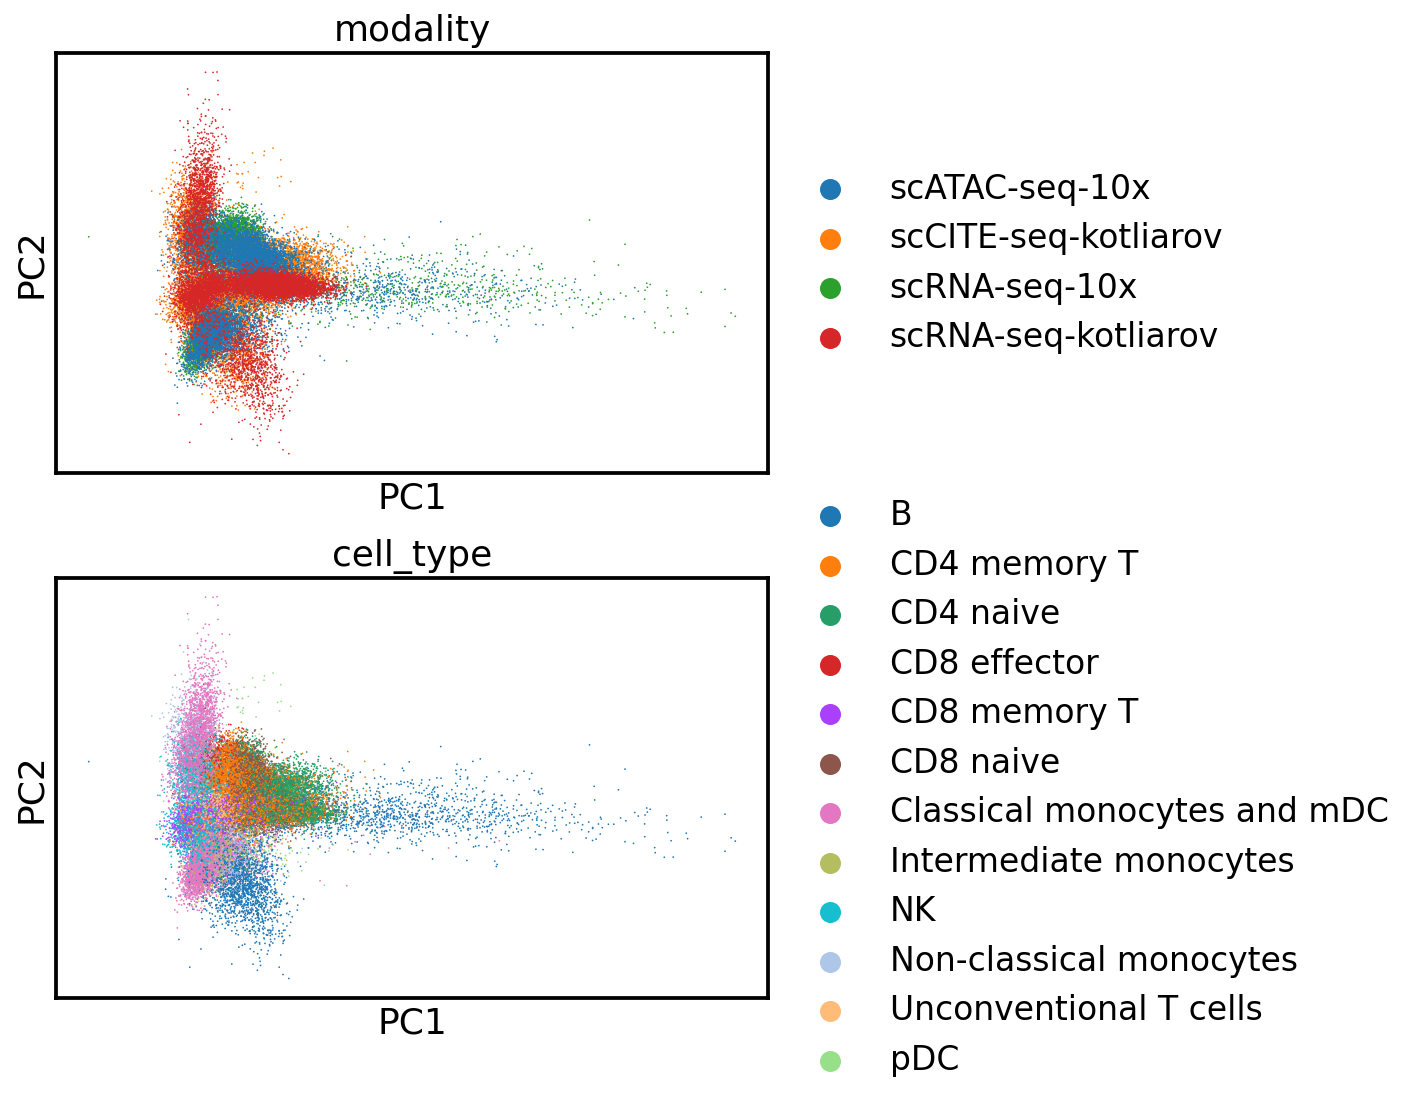

In [23]:
sc.pl.pca(z, color=['modality', 'cell_type'], ncols = 1)

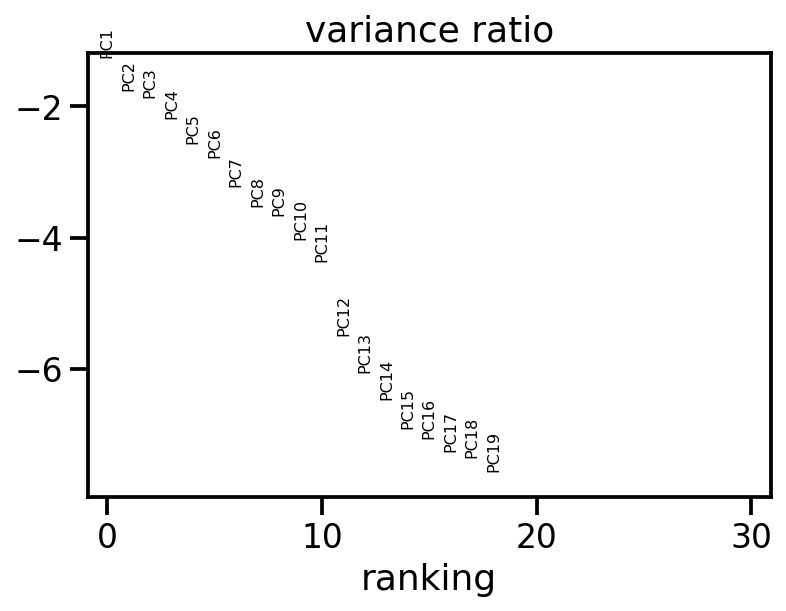

In [24]:
sc.pl.pca_variance_ratio(z, log=True)

In [25]:
sc.pp.neighbors(z)

/Users/alitinet/opt/miniconda3/envs/mulgr/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/Users/alitinet/opt/miniconda3/envs/mulgr/lib/python3.7/site-packages/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities


In [26]:
sc.tl.umap(z)

/Users/alitinet/opt/miniconda3/envs/mulgr/lib/python3.7/site-packages/scanpy/tools/_umap.py:147: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'].tocoo(),


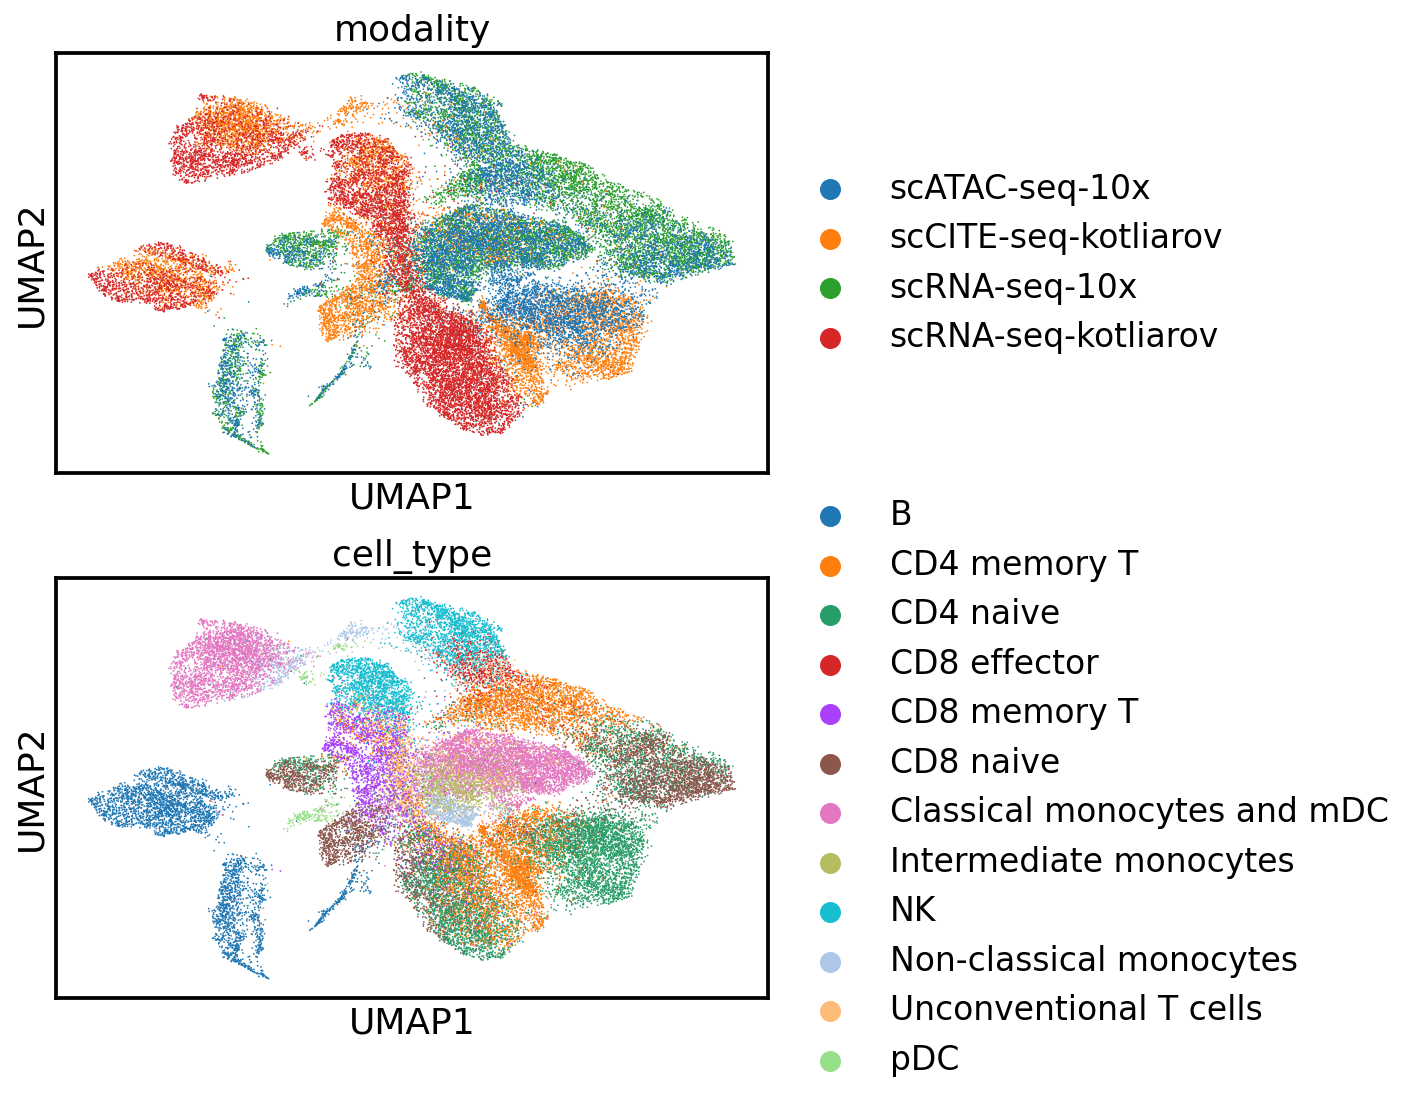

In [27]:
sc.pl.umap(z, color=['modality', 'cell_type'], ncols=1)

# Metrics

In [28]:
scmulti.metrics.nmi(z, label_key='modality')

0.01293906260275825

In [29]:
scmulti.metrics.asw(z, label_key='modality')

-0.009700105525553226

In [ ]:
metrics = scmulti.metrics.scibmetrics.metrics(
    z, z,
    batch_key='modality',
    label_key='cell_type',
    hvg_score_=False,
    nmi_=True,
    ari_=True,
    silhouette_=True,
)
metrics